How weather is impacting the electricity demand in Victoria?
1.	Check if there is a correlation between Max temperature and Electricity demand for CITIPOWER distributor.
H1 : When Max temperature is > T_Median electricity demand is > D_Median
H0 : No such relationship

2.	Do the similar analysis for Rain and Solar

In [512]:
import pandas as pd
import datetime
import glob
import calendar
import matplotlib.pyplot as plt

In [513]:
def refactor_weather_data(bomDF,year):    
    dateslist = pd.date_range(start=f'1/1/{year}', end=f'31/12/{year}')
    weatherlist  = bomDF['Jan'].tolist()
    if calendar.isleap(year):
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:29]
    else:
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:28]          
    weatherlist = weatherlist + bomDF['Mar'].tolist() + bomDF['Apr'].tolist()[0:30] + bomDF['May'].tolist() + bomDF['Jun'].tolist()[0:30] + bomDF['Jul'].tolist() + bomDF['Aug'].tolist() + bomDF['Sep'].tolist()[0:30] + bomDF['Oct'].tolist() + bomDF['Nov'].tolist()[0:30] + bomDF['Dec'].tolist()

    weatherDF = pd.DataFrame({'Date': dateslist, 'Measure': weatherlist})
    return weatherDF


In [514]:

dir = 'BOM/Resources/Weather/_*.csv'
files = glob.glob(dir)
weatherDF = pd.DataFrame()
for f in files:
    filenamelist = f.split("_")
    df = refactor_weather_data(pd.read_csv(f),int(filenamelist[2]))
    df['Distributor'] = filenamelist[1] 
    if filenamelist[3] == '122':
        df['MeasurementType'] = 'MaxTemp'
    elif filenamelist[3] == '123':
        df['MeasurementType'] = 'MinTemp'
    elif filenamelist[3] == '136':
        df['MeasurementType'] = 'Rain Fall'
    elif filenamelist[3] == '193':
        df['MeasurementType'] = 'Solar Exposure'          
    weatherDF = weatherDF.append(df,ignore_index=True)
weatherDF.to_csv('BOM/Resources/Weather/weather.csv')

weatherDF["Measure"] = weatherDF['Measure'].apply(cleanWeatherData)
weatherDF = weatherDF.rename(columns={"Date": "Measure_Date"})
weatherDF.tail()
weatherDF['Measure_Date'] =  pd.to_datetime(weatherDF['Measure_Date'], format="%Y/%m/%d")
weatherDF.head()

,Measure_Date,Measure,Distributor,MeasurementType
0,2015-01-01,26.2,AusNet,MaxTemp
1,2015-01-02,32.5,AusNet,MaxTemp
2,2015-01-03,38.9,AusNet,MaxTemp
3,2015-01-04,25.4,AusNet,MaxTemp
4,2015-01-05,27.3,AusNet,MaxTemp


In [515]:
# data cleansing of measure column
def cleanWeatherData(measure):
    para = str(measure)
    res = '0'
    if para == '↓':
        res = '0'
    elif ' days' in para:        
        res = para[:-4]
    else:
        res = para
    return float(res)

In [516]:
# Load the processed demand data from Electricity Demand Analysis 'Meter data/Demand.csv'

demand_df = pd.read_csv('Meter data/Demand.csv')
demand_df['Measure_Date'] =  pd.to_datetime(demand_df['Measure_Date'], format="%Y/%m/%d")
demand_df = demand_df.loc[demand_df.Measure_Date >= '2015-01-01']
demand_df.reset_index(drop=True, inplace=True)
demand_df.head()    

,Measure_Date,Distributor,Daily_Demand,Business_Demand,Non_Business_Demand
0,2015-01-01,CITIPOWER,3640095.729,1554433,2085662
1,2015-01-02,CITIPOWER,5323070.506,2494996,2828074
2,2015-01-03,CITIPOWER,6340175.938,0,6340175
3,2015-01-04,CITIPOWER,4166689.963,0,4166689
4,2015-01-05,CITIPOWER,4692296.654,2360233,2332063


In [517]:
Vicdemand_df = demand_df.groupby(['Measure_Date']).agg({'Daily_Demand': "sum",'Business_Demand': "sum",'Non_Business_Demand': "sum"})
VicdemandDaily_df = pd.DataFrame(Vicdemand_df['Daily_Demand'])

VicdemandDaily_df.tail()

,Daily_Demand
Measure_Date,
2019-06-26,5.480499e+07
2019-06-27,5.144028e+07
2019-06-28,4.640368e+07
2019-06-29,5.066225e+07
2019-06-30,5.049438e+07


In [518]:
MaxTempDF = weatherDF.loc[weatherDF.MeasurementType == 'MaxTemp']
MaxTempDF = MaxTempDF.loc[((MaxTempDF.Measure_Date >= '2015-01-01') & (MaxTempDF.Measure_Date < '2019-07-01'))]
MaxTempDF = MaxTempDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})
MaxTempDF.tail()



,Measure
Measure_Date,
2019-06-26,16.72
2019-06-27,16.02
2019-06-28,18.16
2019-06-29,16.78
2019-06-30,13.04


In [519]:
VicDailyDemand_MaxTemp = VicdemandDaily_df.merge(MaxTempDF, left_index=True, right_index=True)
VicDailyDemand_MaxTemp.head()

,Daily_Demand,Measure
Measure_Date,,
2015-01-01,2.875675e+07,26.78
2015-01-02,4.472684e+07,38.02
2015-01-03,5.476333e+07,38.82
2015-01-04,3.151786e+07,23.44
2015-01-05,3.225505e+07,25.02


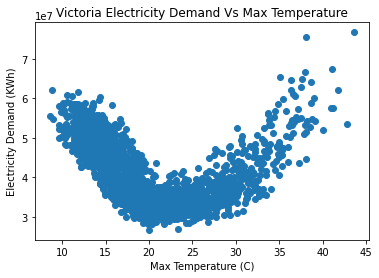

In [521]:
# VicDailyDemand_MaxTemp.plot(x='Measure', y='Daily_Demand', style='o')
plt.scatter(VicDailyDemand_MaxTemp['Measure'], VicDailyDemand_MaxTemp['Daily_Demand'])
plt.xlabel("Max Temperature (C)")
plt.ylabel("Electricity Demand (KWh)")
plt.title("Victoria Electricity Demand Vs Max Temperature")
plt.show()